In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedispersion
import filterbankio_headerless
import matplotlib

%matplotlib inline

In [2]:
# watermark
lofarFil = '/oxford_data/FRBSurvey/Archive/Beam2_fb_D20170206T014224.fil'

### LOFAR RADAR Event

In [3]:
# Read in the data using Filterbank class
fil = filterbankio_headerless.Filterbank(lofarFil)
timeFactor = 64
freqFactor = 8

tInt = fil.my_header[5] # set tInt

print(fil.my_header)

freqsHz = fil.freqs * 1e6 # generate array of freqs in Hz

waterfall = np.reshape(fil.data, (fil.data.shape[0], fil.data.shape[2])) # reshape to (n integrations, n freqs)
waterfall = waterfall.reshape(int(waterfall.shape[0]/timeFactor), timeFactor, waterfall.shape[1]).sum(axis=1)
tInt *= timeFactor

Enter a block number: 1038
[148.9, -0.00305176, 4, 1920, 1, 0.00032768]


In [4]:
dm = float(input('Enter the corresponding best dm: '))

ddwaterfall = dedispersion.incoherent(freqsHz, waterfall, tInt, dm, boundary='wrap') # apply dedispersion

waterfall = waterfall.reshape(waterfall.shape[0], int(waterfall.shape[1]/freqFactor), freqFactor).sum(axis=2)
ddwaterfall = ddwaterfall.reshape(ddwaterfall.shape[0], int(ddwaterfall.shape[1]/freqFactor), freqFactor).sum(axis=2)
freqsHz = freqsHz[::freqFactor]

Enter the corresponding best dm: 9.1


In [5]:
# Take the first 8 seconds of data
start_time = 0.0
time_window = 8.

if start_time is None:
    startIdx = 0
else:
    startIdx = int(start_time / tInt)

if time_window is None:
    endIdx = waterfall.shape[0]
else:
    endIdx = startIdx + int(time_window / tInt)
    if endIdx > waterfall.shape[0]:
        endIdx = waterfall.shape[0]

timeSeries = np.sum(waterfall, axis=1)
ddTimeSeries = np.sum(ddwaterfall, axis=1)

timeSeries = timeSeries[startIdx:endIdx]
ddTimeSeries = ddTimeSeries[startIdx:endIdx]
waterfall = waterfall[startIdx:endIdx,:]
ddwaterfall = ddwaterfall[startIdx:endIdx,:]

normTimeSeries = timeSeries / (waterfall.shape[1] * timeFactor)
normDDTimeSeries = ddTimeSeries / (waterfall.shape[1] * timeFactor)

In [6]:
# flatten bandpass
bandpass = np.tile(waterfall[80:].mean(axis=0).reshape(-1, 1), waterfall.shape[0]).T
#bandpass = np.tile(waterfall[:10].mean(axis=0).reshape(-1, 1), waterfall.shape[0]).T
#waterfallNorm = waterfall - bandpass
waterfallNorm = waterfall

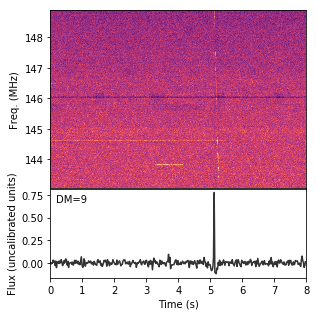

In [7]:
cmap = 'magma'

fig = plt.figure(figsize=(4.5,4.5)) # (width, height)

gs = matplotlib.gridspec.GridSpec(3,3)
gs.update(hspace=0.0, wspace=0.0)

ax1 = plt.subplot(gs[0:2,0:3])
imRaw = plt.imshow(np.flipud(waterfallNorm.T), extent=(0, tInt*waterfall.shape[0], fil.freqs[0], fil.freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')


#plt.title('ARTEMIS Event (t: %i f: %i)'%(timeFactor, freqFactor))
plt.ylabel('Freq. (MHz)')
ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot(gs[2:3,0:3])

lineColor = 'k'
plt.plot(tInt*np.arange(waterfall.shape[0]), normDDTimeSeries, lineColor, alpha=0.8)
plt.xlim(0, tInt*timeSeries.shape[0])

plt.text(0.02, 0.85, 'DM=%0.f'%dm, transform=ax2.transAxes)
plt.xlabel('Time (s)')

plt.ylabel('Flux (uncalibrated units)')

plt.tight_layout()

#print fil.freqs[1] - fil.freqs[0]

#plt.savefig('../figures/LOFAR_dynamic.pdf')

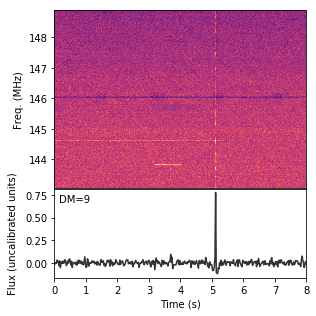

In [8]:
cmap = 'magma'

fig = plt.figure(figsize=(4.5,4.5)) # (width, height)

gs = matplotlib.gridspec.GridSpec(3,3)
gs.update(hspace=0.0, wspace=0.0)

ax1 = plt.subplot(gs[0:2,0:3])

imRaw = plt.imshow(np.flipud(ddwaterfall.T), extent=(0, tInt*ddwaterfall.shape[0], fil.freqs[0], fil.freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

#plt.title('ARTEMIS Event (t: %i f: %i)'%(timeFactor, freqFactor))
plt.ylabel('Freq. (MHz)')
ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot(gs[2:3,0:3])
lineColor = 'k'
plt.plot(tInt*np.arange(waterfall.shape[0]), normDDTimeSeries, lineColor, alpha=0.8)
plt.xlim(0, tInt*timeSeries.shape[0])
#plt.title('Time Series (DM=%0.f)'%dm)
#plt.title('DM=%0.f'%dm)
plt.text(0.02, 0.85, 'DM=%0.f'%dm, transform=ax2.transAxes)
plt.xlabel('Time (s)')
plt.ylabel('Flux (uncalibrated units)', labelpad=8)

plt.tight_layout()

#plt.savefig('../figures/LOFAR_dynamic_dedisp.pdf')